### FLUID FLOW CONTROL VOLUME MESH GENERATION
###### Yigit Saygili - Athens Nov24 ENSAM

Mesh generation for a 2D fluid flow control volume problem involves discretizing the problem domain (the control volume) into smaller, non-overlapping elements, typically triangles or quadrilaterals, to create a computational grid. This grid enables numerical methods, such as Computational Fluid Dynamics (CFD), to solve the governing fluid flow equations, such as the Navier-Stokes equations. The mesh is designed to capture the geometry of the control volume accurately, ensuring fine resolution near important features like boundaries, walls, or regions with high gradients (e.g., velocity or pressure). The mesh must be structured or unstructured, depending on the complexity of the geometry, and it must be refined in regions where greater accuracy is needed, such as in areas with strong flow variations or boundary layers, to ensure reliable and efficient simulation results.

#### 1- Importing the Packages

This code imports the Gmsh package, which is a popular tool for mesh generation, enabling the creation and manipulation of geometric models and computational grids for simulations. It also imports the LinearAlgebra module, which provides functions and types for performing various linear algebra operations such as matrix manipulation, solving linear systems, and eigenvalue problems. Additionally, the Plots package is imported to enable data visualization, allowing the user to generate a variety of plots and graphs to represent data. These imports together suggest the code might be used for mesh-based simulations and numerical computations, potentially visualizing results graphically.

In [1]:
import Gmsh: gmsh
using LinearAlgebra
using Plots

#### 2- Defining a Function for Generating the Coordinates of a Circle

This function generates the coordinates of points evenly spaced along the circumference of a circle. The function takes three inputs: center, radius and number of elements. The x and y coordinates of each point are calculated using basic trigonometric functions, and the resulting points are stored in the points list. Finally, the function returns the list of points as tuples of coordinates.

In [2]:
function circle_coordinates(center::Tuple{Float64, Float64}, radius::Float64, num_points::Int)
    points = []
    for i in 1:num_points
        angle = 2 * π * (i - 1) / num_points
        x = center[1] + radius * cos(angle)
        y = center[2] + radius * sin(angle)
        push!(points, (x, y))
    end
    return points
end

circle_coordinates (generic function with 1 method)

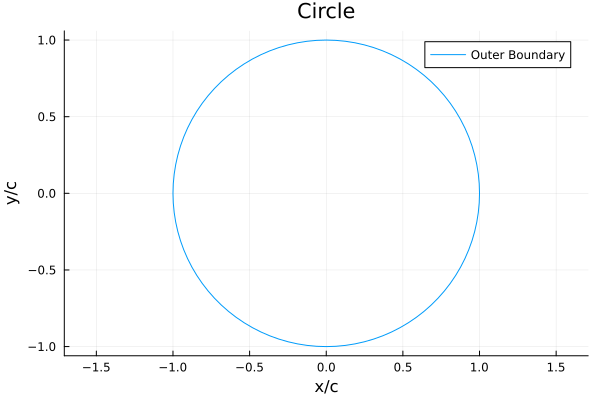

In [3]:
points = circle_coordinates((0.0,0.0), 1.0, 100)

push!(points, points[1])
x_points = [p[1] for p in points]
y_points = [p[2] for p in points]
plot(x_points, y_points, label= "Outer Boundary", xlabel="x/c", ylabel="y/c", title="Circle", ratio=1)

#### 3- Defining a Function for Generating the Coordinates of an Airfoil

This function defines naca_4digit that generates the coordinates of a NACA 4-digit airfoil based on the given parameters. The function takes four inputs:

- m (maximum camber)
- p (position of the maximum camber)
- t (thickness)
- n_points (number of points used to represent the airfoil)

The camber line (y_c) is computed in two sections: for x[i] less than p, a parabolic equation is used, and for x[i] greater than p, another parabolic equation applies. The thickness distribution (y_t) is calculated using a standard formula for NACA airfoils. The upper and lower surface coordinates (y_u and y_l) are obtained by adding and subtracting the thickness, respectively, from the camber line. The code then combines the upper and lower surface points by concatenating them in reverse order to create a closed loop of coordinates, which is returned as a list of (x, y) tuples representing the full airfoil shape.

In [4]:
function naca_4digit(m, p, t, n_points)
    p /= 100
    m /= 100
    t /= 100
    c = 1.0
    x = LinRange(0, 1, n_points)

    y_c = zeros(n_points)
    for i in 1:n_points
        if x[i] < p
            y_c[i] = (m / p^2) * (2 * p * x[i] - x[i]^2)
        else
            y_c[i] = (m / (1 - p)^2) * ((1 - 2 * p) + 2 * p * x[i] - x[i]^2)
        end
    end

    y_t = 5 * t * c * (0.2969 * sqrt.(x) .- 0.1260 * x .- 0.3516 .* x.^2 .+ 0.2843 .* x.^3 .- 0.1015 .* x.^4)
    y_u = y_c .+ y_t
    y_l = y_c .- y_t

    x_coords = vcat(x, reverse(x))
    y_coords = vcat(y_u, reverse(y_l))

    combined_coords = Tuple{Float64, Float64}[]
    for i in 1:n_points * 2
        push!(combined_coords, (x_coords[i], y_coords[i]))
    end

    return combined_coords
end

naca_4digit (generic function with 1 method)

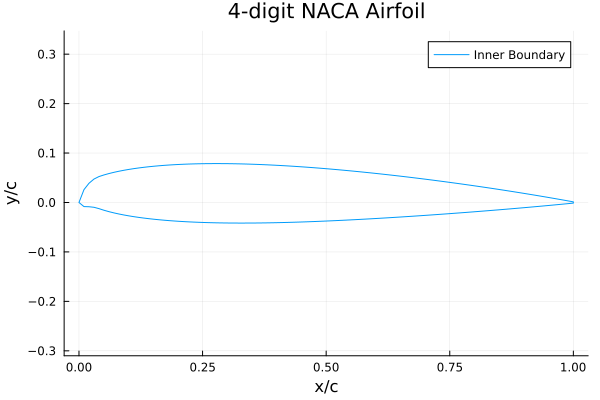

In [5]:
function plot_airfoil(m, p, t, n)
    coords = naca_4digit(m, p, t, n)
    x_values = [coord[1] for coord in coords]
    y_values = [coord[2] for coord in coords]
    plot(x_values, y_values, label="Inner Boundary", xlabel="x/c", ylabel="y/c", title="4-digit NACA Airfoil", ratio = 1)
end

# Example: NACA 2412
plot_airfoil(2, 4, 12, 100)

#### 4- Defining a Function for Generating the Control Volume Mesh

The main function creates a 2D mesh for a "donut-shaped" geometry using the Gmsh library. The function takes four inputs: outer_vertices and inner_vertices (lists of coordinates for the outer and inner circles, respectively), and lc_outer and lc_inner (local mesh sizes for the outer and inner circles).

It initializes Gmsh and sets up a new model. Then, it generates points for both the outer and inner circles, assigning them appropriate mesh resolutions. Next, the function creates boundary lines connecting the points of both circles. Afterward, it defines two curve loops to represent the outer boundary and inner hole, and a plane surface is created to form the donut shape.

The geometry is synchronized with Gmsh, and a 2D mesh is generated. The resulting mesh is optionally written to a file and visualized using Gmsh's graphical user interface. Finally, Gmsh is finalized to clean up resources. This function allows for the creation of a custom 2D mesh for a domain with a circular hole.

In [6]:
function generate_mesh(outer_vertices::Vector{}, inner_vertices::Vector{}, lc_outer::Float64, lc_inner::Float64)
    # 1/7: Initialize Gmsh
    gmsh.initialize()

    # 2/7: Create a new model and set terminal output
    gmsh.option.setNumber("General.Terminal", 1)
    gmsh.model.add("donut_shape_circles")

    # 3/7: Generate points for the outer and inner circles
    outer_points = Int[]
    inner_points = Int[]

    # Define outer circle points with local mesh resolution
    for i in 1:length(outer_vertices)
        x, y = outer_vertices[i]
        # Assign outer mesh resolution to each point in the outer circle
        point_label = gmsh.model.geo.addPoint(x, y, 0, lc_outer, i)
        push!(outer_points, point_label)
    end

    # Define inner circle points with local mesh resolution
    for i in 1:length(inner_vertices)
        x, y = inner_vertices[i]
        # Assign inner mesh resolution to each point in the inner circle (hole)
        point_label = gmsh.model.geo.addPoint(x, y, 0, lc_inner, i + length(outer_vertices))
        push!(inner_points, point_label)
    end

    # 4/7: Define lines (edges) for the outer and inner circles
    outer_lines = Int[]
    inner_lines = Int[]

    # Create the outer boundary lines (connect consecutive points on the outer circle)
    for i in 1:length(outer_points)
        start_point = outer_points[i]
        end_point = outer_points[mod(i, length(outer_points)) + 1]
        push!(outer_lines, gmsh.model.geo.addLine(start_point, end_point, i))
    end

    # Create the inner boundary lines (connect consecutive points on the inner circle)
    for i in 1:length(inner_points)
        start_point = inner_points[i]
        end_point = inner_points[mod(i, length(inner_points)) + 1]
        push!(inner_lines, gmsh.model.geo.addLine(start_point, end_point, i + length(outer_points)))
    end

# 5/7: Define two curve loops (one for the outer boundary and one for the inner hole)
outer_loop = gmsh.model.geo.addCurveLoop(outer_lines, 1)
inner_loop = gmsh.model.geo.addCurveLoop(inner_lines, 2)

# 6/7: Define the surface (donut shape with hole)
gmsh.model.geo.addPlaneSurface([1, 2], 1)

# 7/7: Synchronize geometry with Gmsh
gmsh.model.geo.synchronize()

# 8/7: Generate mesh
gmsh.model.mesh.generate(2)

# 9/7: Write mesh to file (optional)
gmsh.write("data/donut_shape_circles.msh")

# 10/7: Visualize the mesh using Gmsh GUI (optional)
gmsh.fltk.run()

# 11/7: Finalize Gmsh
gmsh.finalize()
end

generate_mesh (generic function with 1 method)

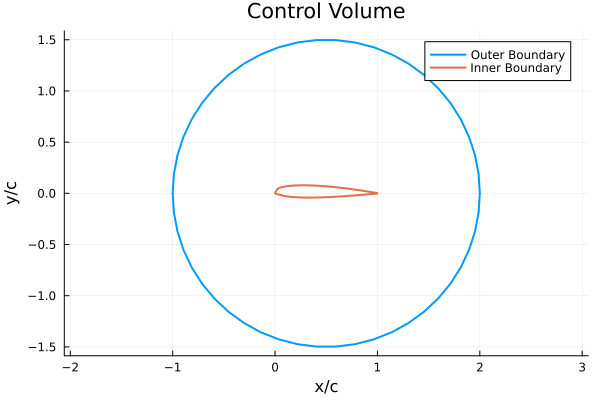

In [7]:
function plot_control_volume(m, p, t, ni, cx, cy, r, no)
    coords = naca_4digit(m, p, t, ni)
    x_values = [coord[1] for coord in coords]
    y_values = [coord[2] for coord in coords]

    # Generate circle coordinates
    points = circle_coordinates((cx, cy), r ,no)
    
    # To close the circle, add the first point to the end
    push!(points, points[1])

    # Extract x and y coordinates of the circle
    x_points = [p[1] for p in points]
    y_points = [p[2] for p in points]

    # Plot the circle first, then overlay the NACA airfoil
    plot(x_points, y_points, label="Outer Boundary", xlabel="x/c", ylabel="y/c", title="Control Volume", ratio=1, linewidth=2)
    plot!(x_values, y_values, label="Inner Boundary", linewidth=2)
end

plot_control_volume(2, 4, 12, 50, 0.5, 0.0, 1.5, 50)

#### 5- Obtaining the Coordinates of Inner and Outer Boundaries

To define the control volume boundaries, a grater circle is generated as the outer boundary with the relevant function. For the inner boundary a generic NACA 2412 airfoil is defined using the presented function with necessray number of surface panels that match the mesh size which will be defined below.

In [8]:
outer_vertices = circle_coordinates((0.0,0.0), 2.0, 20)
inner_vertices = naca_4digit(2, 4, 12, 10)

20-element Vector{Tuple{Float64, Float64}}:
 (0.0, 0.0)
 (0.1111111111111111, 0.06849052583447644)
 (0.2222222222222222, 0.07776105048780675)
 (0.3333333333333333, 0.07790781892874858)
 (0.4444444444444444, 0.07253832761774119)
 (0.5555555555555556, 0.06334607498587622)
 (0.6666666666666666, 0.05128091697584784)
 (0.7777777777777778, 0.0368473237335028)
 (0.8888888888888888, 0.02021348529202871)
 (1.0, 0.0012599999999999777)
 (1.0, -0.0012599999999999777)
 (0.8888888888888888, -0.011490062795458061)
 (0.7777777777777778, -0.020472152265738737)
 (0.6666666666666667, -0.02832567006226759)
 (0.5555555555555556, -0.034882426151857014)
 (0.4444444444444444, -0.03963795038866026)
 (0.33333333333333337, -0.04164238682998314)
 (0.2222222222222222, -0.03920223704473405)
 (0.11111111111111116, -0.0287100045724737)
 (0.0, 0.0)

#### 6- Generating the Mesh Inside the Control Volume

Between two boundaries a triangular mesh is generated using the main mesh generation function. The elements size decreases from outer boundary to inner boundary. Which is necessary for a 2D fluid flow solver to calculate important aerodynamic phenomena arounda the airfoil surface.

In [9]:
generate_mesh(outer_vertices, inner_vertices, 0.1, 0.01)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 20%] Meshing curve 5 (Line)
Info    : [ 20%] Meshing curve 6 (Line)
Info    : [ 20%] Meshing curve 7 (Line)
Info    : [ 20%] Meshing curve 8 (Line)
Info    : [ 30%] Meshing curve 9 (Line)
Info    : [ 30%] Meshing curve 10 (Line)
Info    : [ 30%] Meshing curve 11 (Line)
Info    : [ 30%] Meshing curve 12 (Line)
Info    : [ 40%] Meshing curve 13 (Line)
Info    : [ 40%] Meshing curve 14 (Line)
Info    : [ 40%] Meshing curve 15 (Line)
Info    : [ 40%] Meshing curve 16 (Line)
Info    : [ 50%] Meshing curve 17 (Line)
Info    : [ 50%] Meshing curve 18 (Line)
Info    : [ 50%] Meshing curve 19 (Line)
Info    : [ 50%] Meshing curve 20 (Line)
Info    : [ 60%] Meshing curve 21 (Line)
Info    : [ 60%] Meshing curve 22 (Line)
Info    : [ 60%] Meshing curve 23 (Line)
Info    : [ 60%] Meshing curve 24 (Line)
I

#### 7- Refining the Mesh

When generating a 2D airfoil mesh, the key factors to consider are element size and mesh density. Element size refers to the spacing between mesh points, which influences the accuracy of the simulation; smaller elements lead to higher resolution and more accurate results, particularly in regions with steep gradients like the leading edge, trailing edge, and boundary layers. Mesh density, which defines how finely the domain is discretized, should be higher near the airfoil surface where the flow features (such as velocity and pressure variations) are most significant.

In contrast, the mesh can be coarser farther away from the airfoil to reduce computational cost. The distribution of mesh density is also important—using a finer mesh near the airfoil and gradually coarser elements away from the surface is common. Proper mesh refinement ensures accurate results without excessive computational expense, and a well-distributed mesh avoids introducing numerical errors or inefficiencies in simulation.

In [10]:
control_volume_center_x = 0.5
control_volume_center_y = 0.0
control_volume_radius = 3.0
outer_boundary_panel_number = 50

airfoil_camber = 2
airfoil_camber_location = 4
airfoil_thickness = 12
inner_boundary_panel_number = 50

outer_boundary_mesh_size = 0.5
inner_boundary_mesh_size = 0.1

outer_vertices = circle_coordinates((control_volume_center_x, control_volume_center_y), control_volume_radius, outer_boundary_panel_number)
inner_vertices = naca_4digit(airfoil_camber, airfoil_camber_location, airfoil_thickness, inner_boundary_panel_number)
generate_mesh(outer_vertices, inner_vertices, outer_boundary_mesh_size, inner_boundary_mesh_size)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 10%] Meshing curve 5 (Line)
Info    : [ 10%] Meshing curve 6 (Line)
Info    : [ 10%] Meshing curve 7 (Line)
Info    : [ 10%] Meshing curve 8 (Line)
Info    : [ 10%] Meshing curve 9 (Line)
Info    : [ 10%] Meshing curve 10 (Line)
Info    : [ 10%] Meshing curve 11 (Line)
Info    : [ 10%] Meshing curve 12 (Line)
Info    : [ 10%] Meshing curve 13 (Line)
Info    : [ 10%] Meshing curve 14 (Line)
Info    : [ 10%] Meshing curve 15 (Line)
Info    : [ 20%] Meshing curve 16 (Line)
Info    : [ 20%] Meshing curve 17 (Line)
Info    : [ 20%] Meshing curve 18 (Line)
Info    : [ 20%] Meshing curve 19 (Line)
Info    : [ 20%] Meshing curve 20 (Line)
Info    : [ 20%] Meshing curve 21 (Line)
Info    : [ 20%] Meshing curve 22 (Line)
Info    : [ 20%] Meshing curve 23 (Line)
Info    : [ 20%] Meshing curve 24 (Line)
I